In [1]:
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
import csv
import os
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from torchtext.data import get_tokenizer
import string
import math
from transformers import BertTokenizer, BertModel
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
from tqdm import tqdm

# Définition de START et END pour éviter des fautes de frappe :

START = "<start>"
END = "<end>"

DATASET_PATH = 'dataset/Flicker8k_Dataset/'

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [2]:
# Charger le tokenizer BERT
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Charger le modèle BERT
bert = BertModel.from_pretrained('bert-base-uncased')

bert.to(device)
def extract_text_features(description):
    tokens = tokenizer.encode(description, add_special_tokens=True)

    # Conversion des tokens en tenseur PyTorch
    tokens_tensor = torch.tensor([tokens]).to(device)

    # Encodage du texte avec le modèle BERT
    with torch.no_grad():
        outputs = bert(tokens_tensor)

    # Récupération de la représentation du texte
    last_hidden_state = outputs[0]
    return torch.mean(last_hidden_state, dim=1).squeeze()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [30]:
import csv
url_flicker_train = 'dataset_train.csv';
def flicker_source(fName):
    """
    Une fonction qui charge un jeu de données, et renvoie un générateur
    permettant de le parcourir.

    Résultat:
        un générateur renvoyant des couples de string "nom d'image", "label de l'image"
    """
    images = []
    descriptions = []
    similarites = []
    with open(fName, encoding='utf-8') as f:
        reader = csv.reader(f, delimiter='\t')
        next(reader) # skip the first row (column headers)
        for row in reader:
            texte, image, similarite = row
            images.append(image)
            descriptions.append(texte)
            similarites.append(similarite)
        return descriptions, images, similarites
def flicker_train():
    return flicker_source(url_flicker_train)

def flicker_evaluation():
    return flicker_source('dataset_evaluation.csv')

In [4]:
training_descriptions, training_images, train_similarites = flicker_train()

In [5]:
print(training_descriptions[0])

<start> A black dog is running after a white dog in the snow . <end>


In [6]:
description_features = []
for description in tqdm(training_descriptions, desc="Traitement en cours", unit="s"):
    description = description.replace(START, '')
    description = description.replace(END, '')
    description_features.append(extract_text_features(description))

Traitement en cours: 100%|██████████| 60000/60000 [07:09<00:00, 139.79s/s]


In [7]:
import csv
features_images = []
# Ouvrir le fichier CSV en mode lecture

feature_csv = {}
with open('vgg.csv', 'r', newline='') as fichier_csv:
    # Créer un objet reader pour lire le fichier CSV
        reader = csv.reader(fichier_csv, delimiter='\t')  # Assurez-vous de spécifier le bon délimiteur utilisé dans votre fichier CSV
        next(reader)
        # Parcourir les lignes du fichier CSV
        for row in reader:
            image, feature_image = row
            string = feature_image.replace('tensor(', '').replace('device=\'cuda:0\', grad_fn=<ReshapeAliasBackward0>)', '').replace(')', '').replace('[', '').replace('],', '').replace(" ", "").replace("\n", "")
            strings = string.split(',')
            floats = [float(x) for x in strings]
            feature_csv[image] = torch.tensor(floats, dtype=torch.float32).to(device)
            

In [8]:
features_images = []
for training_image in tqdm(training_images, desc="Traitement en cours", unit="s"):
    features_images.append(feature_csv[training_image])
    

Traitement en cours: 100%|██████████| 60000/60000 [00:00<00:00, 3741851.76s/s]


In [9]:
import torch
from torch.utils.data import Dataset
from PIL import Image
from torchvision.transforms import transforms
import random


class ImageTextSimilarityDataset(Dataset):
    def __init__(self, images_features, description_features, similarites):
        self.images_features = images_features
        self.description_features = description_features
        self.similarites = similarites

    def __len__(self):
        return len(self.images_features)

    def __getitem__(self, index):

        image = self.images_features[index]

        # Obtenir la description textuelle
        text = self.description_features[index]

        # Obtenir l'étiquette de similarité
        label = torch.tensor(int(self.similarites[index])).to(device)

        return image, text, label

In [10]:
# Créer une instance du dataset
import numpy as np

dataset = ImageTextSimilarityDataset(features_images, description_features, train_similarites)

# Utiliser le dataset dans un dataloader pour l'entraînement du modèle
dataloader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=True)


In [11]:
# Créer une instance du dataset
import numpy as np

evaluation_descriptions, evaluation_images, evaluation_similarites = flicker_evaluation()

evaluation_description_features = []
for description in tqdm(evaluation_descriptions, desc="Traitement en cours", unit="s"):
    description = description.replace(START, '')
    description = description.replace(END, '')
    evaluation_description_features.append(extract_text_features(description))
    
evaluation_features_images = []
for evaluation_image in tqdm(evaluation_images, desc="Traitement en cours", unit="s"):
    evaluation_features_images.append(feature_csv[evaluation_image])
    
dataset = ImageTextSimilarityDataset(evaluation_features_images, evaluation_description_features, evaluation_similarites)

# Utiliser le dataset dans un dataloader pour l'entraînement du modèle
dataloader_evaluation = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=True)

Traitement en cours: 100%|██████████| 6000/6000 [00:00<00:00, 3357233.72s/s]


In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F



class ImageTextSimilarity(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(ImageTextSimilarity, self).__init__()

        # Image Encoder
        self.image_encoder = nn.Sequential(
            nn.Linear(input_size[0], hidden_size).to(device),
            nn.ReLU().to(device),
            nn.Linear(hidden_size, hidden_size).to(device),
            nn.Dropout(p=0.5).to(device)
        ).to(device)

        # Text Encoder
        self.text_encoder = nn.Sequential(
            nn.Linear(input_size[1], hidden_size).to(device),
            nn.ReLU().to(device),
            nn.Linear(hidden_size, hidden_size).to(device),
            nn.Dropout(p=0.5).to(device)
        ).to(device)

    def forward(self, image, text):
        # Encode image and text
        image_embed = self.image_encoder(image)
        text_embed = self.text_encoder(text)

        # Normalize embeddings
        image_embed = F.normalize(image_embed, p=2, dim=1)
        text_embed = F.normalize(text_embed, p=2, dim=1)

        # Calculate cosine similarity
        similarity = torch.matmul(image_embed, text_embed.t()).to(device)

        return similarity

In [13]:
print(features_images[0].shape[0])
print(description_features[0].shape[0])

1000
768


In [14]:
import torch
import torch.nn as nn
import torch.optim as optim

# Création du modèle
input_size = (features_images[0].shape[0], description_features[0].shape[0]) # Dimensions d'entrée de l'image et du texte
hidden_size = 256 # Dimensionnalité des embeddings
model = ''
model = ImageTextSimilarity(input_size, hidden_size)

# Définition de la fonction de perte
criterion = nn.CosineEmbeddingLoss()

# Définition de l'optimiseur
learning_rate = 0.0001
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

early_stop_patience = 5
eval_loss_best = float('inf')
early_stop_counter = 0
# Entraînement du modèle
num_epochs = 30
for epoch in range(num_epochs):
    model.train()
    for i, (images, texts, labels) in enumerate(dataloader):
        # Remise à zéro des gradients
        optimizer.zero_grad()

        # Passage des données dans le modèle
        image_embed = model.image_encoder(images).to(device)
        text_embed = model.text_encoder(texts).to(device)

        # Normalisation des embeddings
        image_embed = F.normalize(image_embed, p=2, dim=1)
        text_embed = F.normalize(text_embed, p=2, dim=1)
        # Calcul de la perte
        loss = criterion(image_embed, text_embed, labels)

        # Rétropropagation
        loss.backward()
        optimizer.step()

        # Affichage des informations d'entraînement
        if (i + 1) % 100 == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                  .format(epoch + 1, num_epochs, i + 1, len(dataloader), loss.item()))
        
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for i, (evaluation_images, evaluation_texts, evaluation_labels) in enumerate(dataloader_evaluation):
            evaluation_image_embed = model.image_encoder(evaluation_images).to(device)
            evaluation_text_embed = model.text_encoder(evaluation_texts).to(device)

            evaluation_text_embed = F.normalize(evaluation_text_embed, p=2, dim=1)
            evaluation_image_embed = F.normalize(evaluation_image_embed, p=2, dim=1)

            val_loss += criterion(evaluation_image_embed, evaluation_text_embed, evaluation_labels)

        val_loss /= len(dataloader_evaluation)
        print('Epoch [{}/{}], Step [{}/{}], Evaluation Loss: {:.4f}'
              .format(epoch + 1, num_epochs, i + 1, len(dataloader_evaluation), val_loss))
        
    # Vérifier si la performance sur l'ensemble de validation s'est détériorée
    if val_loss < eval_loss_best:
        eval_loss_best = val_loss
        counter = 0
        # Sauvegarder le meilleur modèle
        torch.save(model.state_dict(), 'meilleur_modele.pth')
    else:
        early_stop_counter += 1
        if early_stop_counter >= early_stop_patience:
            model.load_state_dict(torch.load('meilleur_modele.pth'))
            print(f'Arrêt anticipé à l\'époque {epoch + 1}')
            break

Epoch [1/30], Step [100/938], Loss: 0.5194
Epoch [1/30], Step [200/938], Loss: 0.3582
Epoch [1/30], Step [300/938], Loss: 0.4353
Epoch [1/30], Step [400/938], Loss: 0.4049
Epoch [1/30], Step [500/938], Loss: 0.3138
Epoch [1/30], Step [600/938], Loss: 0.4301
Epoch [1/30], Step [700/938], Loss: 0.3341
Epoch [1/30], Step [800/938], Loss: 0.3995
Epoch [1/30], Step [900/938], Loss: 0.3515
Epoch [1/30], Step [94/94], Evaluation Loss: 0.2415
Epoch [2/30], Step [100/938], Loss: 0.4191
Epoch [2/30], Step [200/938], Loss: 0.3985
Epoch [2/30], Step [300/938], Loss: 0.3382
Epoch [2/30], Step [400/938], Loss: 0.3754
Epoch [2/30], Step [500/938], Loss: 0.3624
Epoch [2/30], Step [600/938], Loss: 0.3472
Epoch [2/30], Step [700/938], Loss: 0.3744
Epoch [2/30], Step [800/938], Loss: 0.3607
Epoch [2/30], Step [900/938], Loss: 0.3043
Epoch [2/30], Step [94/94], Evaluation Loss: 0.2143
Epoch [3/30], Step [100/938], Loss: 0.3808
Epoch [3/30], Step [200/938], Loss: 0.4195
Epoch [3/30], Step [300/938], Loss: 

In [15]:
torch.save(model.state_dict(), 'premier_modele_qui_marche.pth')

In [43]:
import os
def get_top_k_best_picture(description, top_k ):
    description = extract_text_features(description)
    text_embedding = model.text_encoder(description).to(device) 
    
    contenu_dossier = os.listdir(DATASET_PATH)
    results = {}
    tops = [] 
    for element in tqdm(contenu_dossier, desc="Traitement en cours", unit="s"):
        if element == '.ipynb_checkpoints':
            continue
        image = feature_csv[element]
        image_embedding = model.image_encoder(image).to(device)
        similarity = torch.cosine_similarity(image_embedding, text_embedding, dim=0)
        
        results[element] = similarity

        if len(tops) < top_k:
            tops.append(element)
        else:
            # Vérifier si la valeur actuelle est supérieure à la plus basse des 10 valeurs les plus élevées
            similarity_min = min(results[cle] for cle in tops)
            if similarity > similarity_min:
                # Remplacer la clé ayant la plus basse valeur par la clé actuelle
                index_min = tops.index(min(tops, key=results.get))
                tops[index_min] = element
            
    return tops

def get_top_k_best_picture_sans_loader(description, top_k ):
    description = extract_text_features(description)
    text_embedding = model.text_encoder(description).to(device) 
    
    contenu_dossier = os.listdir(DATASET_PATH)
    results = {}
    tops = [] 
    for element in contenu_dossier:
        if element == '.ipynb_checkpoints':
            continue
        image = feature_csv[element]
        image_embedding = model.image_encoder(image).to(device)
        similarity = torch.cosine_similarity(image_embedding, text_embedding, dim=0)
        
        results[element] = similarity

        if len(tops) < top_k:
            tops.append(element)
        else:
            # Vérifier si la valeur actuelle est supérieure à la plus basse des 10 valeurs les plus élevées
            similarity_min = min(results[cle] for cle in tops)
            if similarity > similarity_min:
                # Remplacer la clé ayant la plus basse valeur par la clé actuelle
                index_min = tops.index(min(tops, key=results.get))
                tops[index_min] = element
            
    return tops

In [33]:
import csv
url_flicker_train = 'dataset_train.csv';
def flicker_source(fName):
    """
    Une fonction qui charge un jeu de données, et renvoie un générateur
    permettant de le parcourir.

    Résultat:
        un générateur renvoyant des couples de string "nom d'image", "label de l'image"
    """
    images = []
    descriptions = []
    similarites = []
    with open(fName, encoding='utf-8') as f:
        reader = csv.reader(f, delimiter='\t')
        next(reader) # skip the first row (column headers)
        for row in reader:
            texte, image = row
            images.append(image)
            descriptions.append(texte)
        return descriptions, images

def flicker_test():
    return flicker_source('dataset_test.csv')

In [49]:
test_descriptions, test_images = flicker_test()

true_similarity = 0
false_similarity = 0

for i in tqdm(range(len(test_descriptions)), desc="Traitement en cours", unit="s"):
    similaire = False
    description = test_descriptions[i].replace(START, '')
    description = description.replace(END, '')
    tops = get_top_k_best_picture_sans_loader(description, 10)
    similarity_image = 0                                      
    for top in tops:
        similarity_image = torch.cosine_similarity(feature_csv[top], feature_csv[test_images[i]], dim=0)
        if similarity_image > 0.7:
            true_similarity += 1
            similaire = True
            break;
    
    if similaire == False:
        false_similarity += 1
    
                                          
print(true_similarity/len(test_descriptions[:10]))

Traitement en cours: 100%|██████████| 2000/2000 [6:46:40<00:00, 12.20s/s]  

136.0


In [54]:
print(true_similarity/len(test_descriptions))
print(false_similarity/len(test_descriptions))

0.68
0.32


Traitement en cours: 100%|██████████| 8092/8092 [00:12<00:00, 640.35s/s]


['1110208841_5bb6806afe.jpg', '2084103826_ffd76b1e3e.jpg', '2430860418_fd0726f414.jpg', '1351315701_6580b51c41.jpg', '3357937209_cf4a9512ac.jpg', '3375134059_7e9eb2ef01.jpg', '3246804978_ea2c9e56f2.jpg', '1019604187_d087bf9a5f.jpg', '861608773_bdafd5c996.jpg', '3294952558_96bb8c8cf3.jpg']
tensor(0.6618, device='cuda:0')


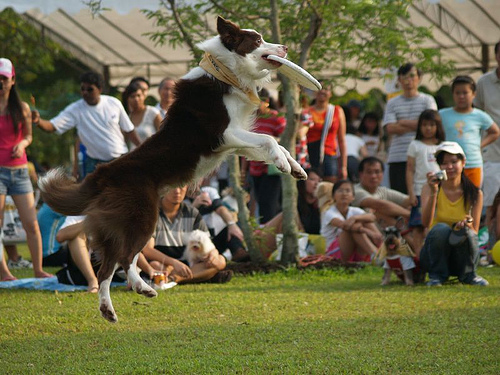

tensor(0.6288, device='cuda:0')


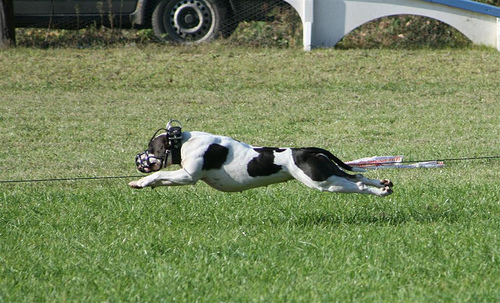

tensor(0.6931, device='cuda:0')


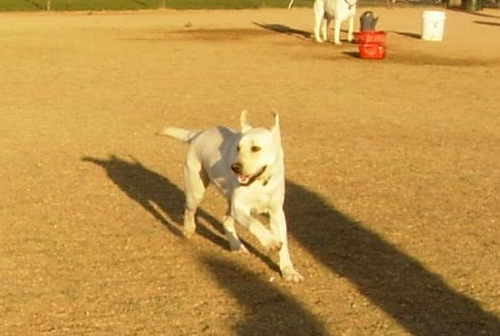

tensor(0.7476, device='cuda:0')


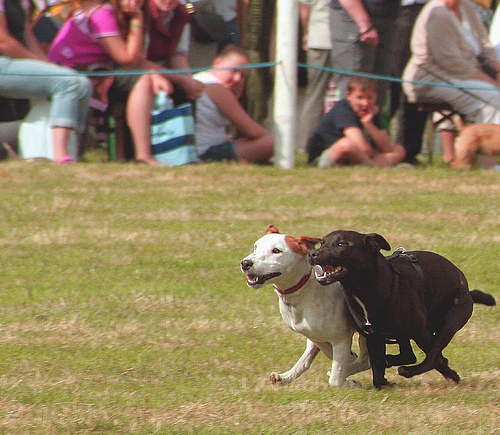

tensor(0.4643, device='cuda:0')


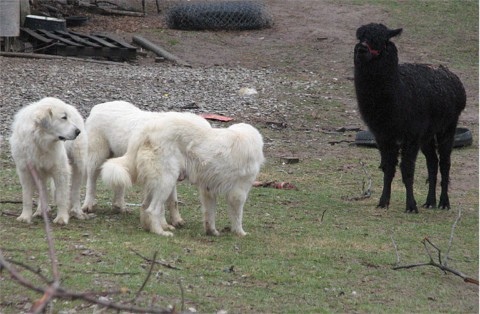

tensor(0.5427, device='cuda:0')


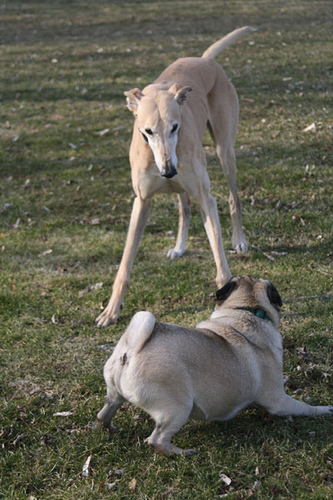

tensor(0.6135, device='cuda:0')


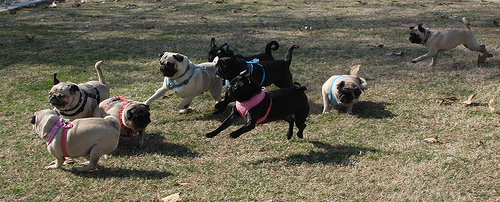

tensor(0.7473, device='cuda:0')


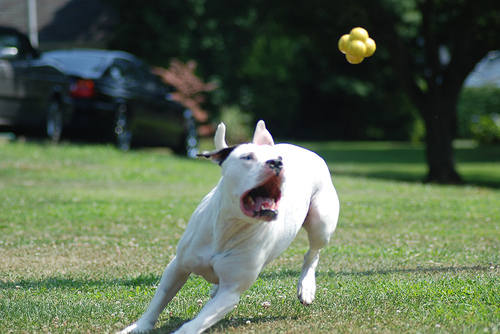

tensor(0.6735, device='cuda:0')


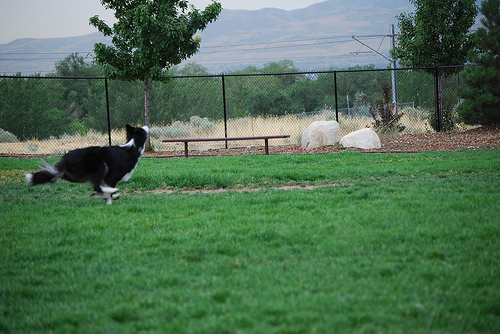

tensor(0.5937, device='cuda:0')


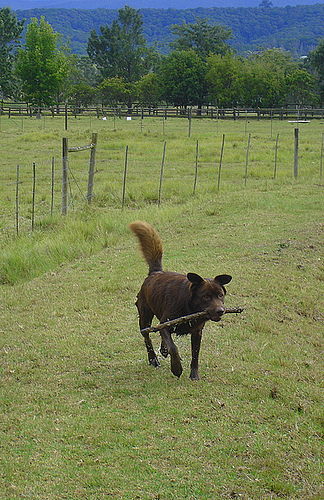

In [55]:
tops = get_top_k_best_picture('A brown and white dogs stands in front of a wooden building while tennis balls fly through the air .', 10)
print(tops)
from PIL import Image
for image_name in tops:
    # Charger l'image
    image = Image.open(DATASET_PATH + image_name)
    # print(image_name)
    print(torch.cosine_similarity(feature_csv[image_name], feature_csv['3490736665_38710f4b91.jpg'], dim=0))
    # Afficher l'image
    image.show()